In [618]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigsh

Let us write a function which creates a matrix consisting of two blocks with prescribed values(later we will write a general with k blocks)

In [619]:
def create_two_blocks(dimension, size1, value11, value12, value22): 
    #Returns a symmetric matrix consisting of two blocks with prescribed values 
    delta = np.zeros((dimension, dimension))
    delta[:size1, :size1] = value11
    delta[size1:, :size1] = value12
    delta[:size1, size1:] = value12
    delta[size1:, size1:] = value22
    return delta

In [620]:
create_two_blocks(10, 4, 1, 3, 5)

array([[1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.]])

### Instance of the problem

Let us generate an instance of the problem with inhomogenous noise (delta instead of snr)

In [621]:
def get_instance(dimension, prior, delta):
    #Returns a ground truth vector and the matrix corrupted by a gaussian noise according to the model
    if prior == 'gaussian':
        true_vector = np.random.normal(0,1, (dimension,1))       
    elif prior == 'rademacher':
        true_vector = np.random.choice([-1,1], size=(dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    corrupted_matrix = np.sqrt(1 / dimension) * true_vector @ true_vector.T + noise * delta

    return true_vector, corrupted_matrix

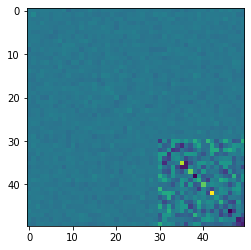

In [622]:
delta = create_two_blocks(dimension = 50, size1 = 30, value11 = 1, value12 = 1, value22 = 8)
Y = get_instance(dimension = 50, prior = 'gaussian', delta = delta)[1]
plt.imshow(Y, interpolation = 'none')
plt.show()

The plot above clearly illustrates the presence of two communities in the generated instance. In the first community the variance is 1 and the color is quite uniform, whereas in the second the variance is 8 and the color varies wildly across different nodes from the same community.

Let us now implement AMP for the inhomegenous noise 

In [623]:
def damp(new, old, damping=0.96):
    return damping * old + (1-damping) * new

def iterate_amp(precision = 1e-4, max_steps = 30, *, init, prior, Y, delta):
    
    N = Y.shape[0]
    
    previous_estimator = np.zeros(N)
    estimator = np.copy(init)
    derivative = np.zeros(N) 
    
    converged = False
    
    for timestep in range(max_steps):   
        snr = np.array([np.mean (estimator**2) / np.mean((delta[j] * estimator)**2) for j in range(N)])
        Onsager_term = np.array([np.mean (delta[j]**2 * derivative) for j in range(N)])
        
        next_step = np.sqrt(1 / N) * Y.T @ estimator - Onsager_term * previous_estimator
        kappa = snr * np.mean(estimator**2) 
            
        previous_estimator = np.copy(estimator)
        estimator, derivative = denoiser_and_derivative(next_step, kappa, snr, prior = prior)
        
        step_difference = np.mean((estimator-previous_estimator)**2)
        
        if (timestep > 2) and (step_difference < precision):
            converged = True
            break
            
    if not converged:
        print("AMP didn't converge!")
    
    return estimator

Now we implement the denoiser functions. Note that with inhomegenous noise both parameters b and a are vectors

In [624]:
def denoiser_and_derivative(to_denoise, kappa, snr, *, prior):
    if(prior == 'gaussian'):
        return to_denoise * snr /(1 + kappa), snr / (1 + kappa) 
    elif prior == 'rademacher':
        return np.tanh(snr * to_denoise), snr * (1-np.tanh(snr * to_denoise)**2)

We now calculate the average performance of AMP over several runs

In [625]:
def get_mse(truth, estimate):
    return np.min([np.mean((truth - estimate)**2), np.mean((truth + estimate)**2)]) #It is impossible to learn the sign

def get_averaged_performance(seeds, dimension, initialisation = 'uninformed', *, prior, delta):
    mse = []
    N = dimension
    for _ in range(seeds):
        init = 1e-3 * np.random.normal(0,1,(N,1)) # default initialisation is uninformed
        # Generate an instance
        truth, Y = get_instance(dimension = dimension, 
                             prior = prior, 
                             delta = delta)
        
        # In informed initialisation starts close to signal
        if initialisation == 'informed':
            init += truth 
        elif initialisation == 'spectral':
            _, init = np.linalg.eigh(Y)[N-1]
            init *= np.sqrt(len(truth))
       
        estimate = iterate_amp(init = init, 
                                 prior = prior, 
                                 Y = Y, 
                                 delta = delta)
        mse.append(get_mse(truth, estimate))
        
    return np.mean(mse)

In [626]:
def data_amp(seeds, dimension, initialisation = 'uninformed', *, delta_collection, prior):
    
    data = {'parameter': [], 'mse': []}
    for delta in delta_collection:
        parameter = delta[0][0]
        print("Computing with parameter = {}".format(parameter))
        
        mse = get_averaged_performance(seeds = seeds,dimension = dimension, 
                                            initialisation = initialisation, 
                                            prior = prior, 
                                            delta = delta)
        
        data['parameter'].append(parameter)
        data['mse'].append(mse)

    return data

In [627]:
def create_two_blocks_collection(dimension, *, start, end, points, first_size, diag_scalar):
    N = dimension
    parameter_range = np.linspace(start, end, points)
    delta_collection = []
    for parameter in parameter_range:
        delta_collection.append(create_two_blocks(N, first_size, parameter, parameter, diag_scalar * parameter))
    return np.array(delta_collection)


Code to solve the variational problem

In [628]:
def Gibbs(qtilde,x0,z):
  p = 0.5
  h = qtilde * x0 + sqrt(qtilde) * z
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))

def Gauss(z):
  return exp(-z*z/2)/sqrt(2*pi)

def ExpectGibbsRad(qtilde):
  p = 0.5
  BOUNDS = 10
  #x0 = 1  
  av_fp = lambda z: Gauss(z) * p * (Gibbs(qtilde,1,z))**2
  av_plus, err = integrate.quad(av_fp, -BOUNDS, BOUNDS)
  #x0 = -1  
  av_fm = lambda z: Gauss(z) * p * (Gibbs(qtilde,-1,z))**2
  av_minus, err = integrate.quad(av_fm, -BOUNDS, BOUNDS)
  #x0 = 0
  av_fz = lambda z: Gauss(z) * (1-2*p) * (Gibbs(qtilde,0,z))**2
  av_zero, err= integrate.quad(av_fz, -BOUNDS, BOUNDS)
  return av_plus + av_zero + av_minus

def ExpectGibbs(qtilde,prior):
  if(prior == 'gaussian'):
        return 1 - 1/(qtilde + 1)
  elif prior == 'rademacher':
        return ExpectGibbsRad(qtilde)

def iterate(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,prior):
  damping = 0.2
  term1 =  ExpectGibbs(Qtilde1,prior)
  term2 = ExpectGibbs(Qtilde2,prior)
  newQtilde1 = (rho1/Delta_11**2) * term1 + (rho2/Delta_12**2) * term2
  newQtilde2 = (rho1/Delta_12**2) * term1 + (rho2/Delta_22**2) * term2
  return (1-damping)*newQtilde1 + damping*Qtilde1, (1-damping)*newQtilde2 + damping*Qtilde2, np.sqrt((newQtilde1-Qtilde1)**2 + (newQtilde2-Qtilde2)**2)

def Solve_Q(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,prior):
    convergence = 1000
    while (convergence > 1e-3):
        Qtilde1, Qtilde2, convergence = iterate(Qtilde1,Qtilde2, rho1, rho2, Delta_11, Delta_12, Delta_22, prior)
        
    return Qtilde1, Qtilde2

In [629]:
def visualize (data_amp, data_optimal):
    fig, ax = plt.subplots(figsize=(12,10))
    plt.plot(data_optimal['parameter'], data_optimal['mse'], 
         '-y', label='Predicted MMSE', color='blue')
    plt.plot(data_amp['parameter'], data_amp['mse'], 
         '.', label='AMP', color='red')
    plt.xlabel('p')
    plt.ylabel('mse')
    plt.legend()

Generating the MMSE

In [630]:
def optimal_curve(start, end, points, diag_scalar,prior):

    rho1, rho2 = 0.5, 0.5

    MMSEVec = []
    paramvec = []

    param_range = np.linspace(start, end, points)

    for param in param_range:
      Delta11 = param
      Delta12 = param
      Delta22 = (diag_scalar*param)
    
      Qtilde1 = 1
      Qtilde2 = 1
    
      Qtilde1, Qtilde2 = Solve_Q(Qtilde1, Qtilde2, rho1, rho2, Delta11, Delta12, Delta22,prior)
      MMSEVec.append(1 - np.sqrt(rho1**2 * ExpectGibbs(Qtilde1,prior)**2 + 
                           2 * rho1 * rho2 *  ExpectGibbs(Qtilde1,prior) * ExpectGibbs(Qtilde2,prior) + 
                           rho2**2 * ExpectGibbs(Qtilde2,prior)**2))
      paramvec.append(param)
    
    return {'parameter': paramvec, 'mse': MMSEVec}


Computing with parameter = 0.05
Computing with parameter = 0.07551020408163266
Computing with parameter = 0.10102040816326531
Computing with parameter = 0.12653061224489798
Computing with parameter = 0.1520408163265306
Computing with parameter = 0.17755102040816328
Computing with parameter = 0.2030612244897959
Computing with parameter = 0.2285714285714286
AMP didn't converge!
Computing with parameter = 0.2540816326530612
AMP didn't converge!
Computing with parameter = 0.2795918367346939
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.3051020408163265
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.3306122448979592
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.35612244897959183
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.38163265306122446
AMP didn't converge!
AMP didn't converge!
AMP did

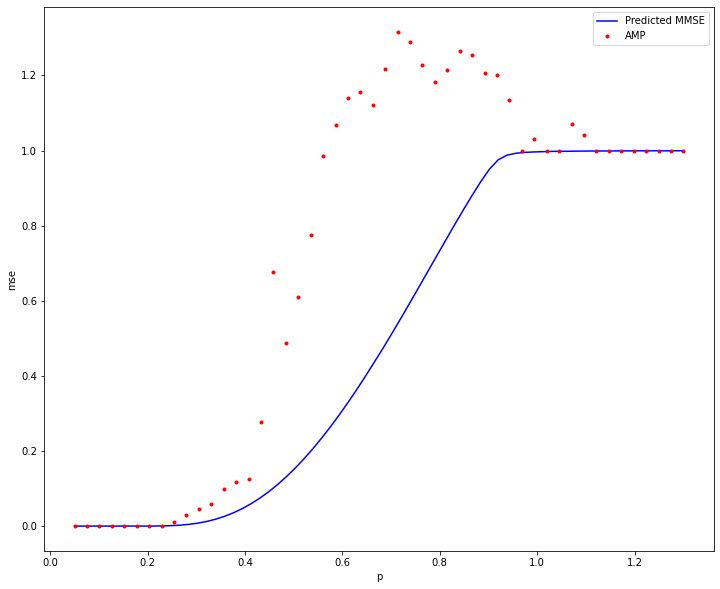

In [631]:
dimension = 100
start = 0.05
end = 1.3
points = 50
delta_collection = create_two_blocks_collection(dimension = dimension, start = start, end = end, points = points, 
                                         first_size = dimension//2, diag_scalar = 2)
amp_curve = data_amp(initialisation = 'uninformed', seeds = 7, dimension = dimension,
                                   delta_collection = delta_collection, prior = 'rademacher')
visualize(data_amp = amp_curve, data_optimal = 
          optimal_curve(start = start, end = end, points = 70, diag_scalar = 2,prior = 'rademacher'))